# REEPS Tutorial - Getting started
## Introduction
In this notebook, you will learn how to use REEPS to fit thermodynamic parameters to experimental data and explore how well the parameters fit.
## Installation
In your terminal run<br/>
```$ git clone https://xgitlab.cels.anl.gov/summer-2020/parameter-estimation.git```<br/>
Navigate into the folder with <br/>
```$ cd parameter-estimation```<br/>
And run <br/>
```pip install -e.```<br/>



## Import and instantiate REEPS

First, you will need to import the package and instantiate REEPS with a few parameters.

In [1]:
import sys  # Navigating to reeps.py since not a package yet
sys.path.append('../../')
from reeps import REEPS
searcher_parameters = {'exp_csv_filename': '../../data/csvs/exp_data.csv',
                       'phases_xml_filename': '../../data/xmls/twophase.xml',
                       'opt_dict': {'Nd(H(A)2)3(org)': {'h0': -4.7e6}},
                       'phase_names': ['HCl_electrolyte', 'PC88A_liquid'],
                       'aq_solvent_name': 'H2O(L)',
                       'extractant_name': '(HA)2(org)',
                       'diluant_name': 'dodecane',
                       'complex_name': 'Nd(H(A)2)3(org)',
                       'rare_earth_ion_name': 'Nd+++',
                       'aq_solvent_rho': 1000.0,
                       'extractant_rho': 960.0,
                       'diluant_rho': 750.0}
searcher = REEPS(**searcher_parameters)

### Parameters explanation 

####  exp_csv_filename

exp_csv_filename is the file name for the csv containing experimental data. <br/>
Let us explore the format of this file with pandas

In [2]:
import pandas as pd
exp_df = pd.read_csv(searcher_parameters['exp_csv_filename'])
exp_df

,HI(m),REeq(m),D(m),ZI(m),Zeq,Heq,REI
0,0.01,0.0239,1.0921,1,0.921696,0.088304,0.050001
1,0.01,0.0683,0.4641,1,0.904906,0.105094,0.099998
2,0.01,0.1170,0.2821,1,0.900983,0.109017,0.150006
3,0.01,0.1680,0.1905,1,0.903988,0.106012,0.200004
4,0.01,0.2637,0.1377,1,0.891066,0.118934,0.300011


The rows are for experiments, and the columns are for the measured quantaties. <br/>
REEPS is looking for the ordering of these columns so it is important your experimental file has this ordering. Column names do not matter.<br/>
Below is a table explaining the meaning of the column headers

| Column  | Meaning                                                                                 |
|---------|-----------------------------------------------------------------------------------------|
|   HI(m) |                                                Initial Concentration of H+ ions (mol/L) |
| REeq(m) | Equilibrium concentration of Rare Earth ions (mol/L)                                    |
|    D(m) | Equilibrium Ratio between amount of rare earth elements in organic to amount in aqueous |
|   ZI(m) | Initial concentration of extractant (mol/L)                                             |
|     Zeq | Equilibrium concentration of extractant (mol/L)                                         |
|     Heq | Equilibrium concentration of H+ ions (mol/L)                                            |
|     REI | Initial concentration of rare earth ions (mol/L)                                        |

#### phases_xml_filename

This is the xml file containing information to be loaded into Cantera, the thermodynamic modeling package. <br/>
Please see parameter-estimation/data/xmls for file examples. <br/>
We can explore what has been loaded.

In [3]:
print(searcher.get_phases())

[<cantera.composite.Solution object at 0x000001B13BE190B8>, <cantera.composite.Solution object at 0x000001B13BE192E8>]


It is a list of two Cantera solutions so we will dig in a little further and see what species these solutions contain.

In [4]:
for phase in searcher.get_phases():
    print(phase.name)
    print(phase.species_names)

HCl_electrolyte
['H2O(L)', 'H+', 'OH-', 'Cl-', 'Nd+++']
PC88A_liquid
['(HA)2(org)', 'dodecane', 'Nd(H(A)2)3(org)']


You can explore Cantera solutions further by visiting https://cantera.org/ and seeing Cantera's documentation.

#### opt_dict

This is a dictionary that contains the information about what species and what thermodynamic properties are to be modified.<br/> 
The number after the thermodynamic property is the initial guess for the optimizer. <br/> 
In this example, we chose to optimize the standard enthalpy (h0) of the neodymium-PC88A complex ('Nd(H(A)2)3(org)') and give it an initial guess of -4.7e6. Thus, <br/> 
```python 
opt_dict={'Nd(H(A)2)3(org)': {'h0': -4.7e6}}```

Say we wanted to also modify the extractant ('(HA)2(org)'), but this time change both the standard enthalpy (h0) and the molar volume (molarVolume), then the dictionary would be
```python 
opt_dict={'Nd(H(A)2)3(org)': {'h0': -4.7e6, 'molarVolume':1.01},
               '(HA)2(org)': {'h0': -4.7e6, 'molarVolume':1.01}}```

#### phase_names

This a list of the phase names in the xml file and can be found in the field phase id.

#### Names and rhos

| Parameter           | Meaning                                      | Example value     |
|---------------------|----------------------------------------------|-------------------|
|     aq_solvent_name |             Name of solvent in aqueous phase | 'H2O(L)'          |
|     extractant_name | Name of extractant in organic phase          | '(HA)2(org)'      |
|        diluant_name | Name of diluant in organic phase             | 'dodecane'        |
|        complex_name | Name of rare earth complex in organic phase  | 'Nd(H(A)2)3(org)' |
| rare_earth_ion_name | Name of rare earth ion name in aqueous phase | 'Nd+++'           |
|                rhos | Density of species (g/L)               | 1000 for 'H2O(L)' |

For the variables containing "rho", these parameters can be left "None", and molecular weight and molar volume will be used to calculate density.<br/> However, molar volume values may be wrong and mess up calculations so it is recommended to find density values and replace the default values.

## Fitting thermodynamic properties to data

Now that the thermodynamic properties have been set, we now need to set up the optimizer. <br/> The default optimizer is from scipy.optimize.minimize with the arguments below. The optimizer optimizes a value multiplied by the initial guess. <br/> Say $x$ is the variable controlled by the minimizer, the value that is entering the objective function is $x\times\mathrm{Guess\,value}$. So for our case, the values tested are $(4.6\times 10^6)x$. This is more important for bounds and constraints.

In [5]:
minimizer_kwargs = {"method": 'SLSQP',
                    "bounds": [(1e-1, 1e1)],
                    "constraints": (),
                    "options": {'disp': True, 
                                'maxiter': 1000, 
                                'ftol': 1e-6}}

With the minimizer arguments defined, we can perform our fit.<br/>
This minimizes the log mean squared error between the predicted and experimental Distribution ratio (D).

In [6]:
est_enthalpy = searcher.fit()
print(est_enthalpy)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.025193288852542232
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
{'Nd(H(A)2)3(org)': {'h0': -4704699.156668724}}


We can see that the fit function returns an identical structure to opt_dict

## Updating the xml

Now we have our new values, let us write them to our original xml to replace the old values

In [7]:
searcher.update_xml(est_enthalpy)

## Visualization and analysis

We can also see how well this new xml data fits to the experimental data with a parity plot.

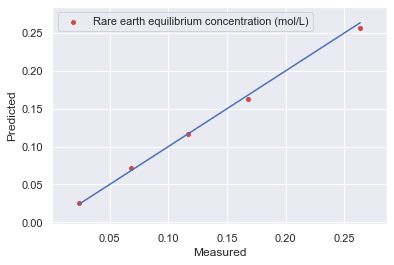

In [8]:
searcher.parity_plot()

We can also find what the r-squared value is. The closer to 1, the better the prediction model.

In [9]:
print(searcher.r_squared())

0.9970803631106648


Yay! Good job! That is an amazing fit.